In [1]:
!pip install yfinance

In [14]:
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from collections import deque
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from datetime import datetime

In [3]:
df = yf.download(["AAPL", "GOOG", "MSFT", "TSLA"], start="2020-01-01", end="2024-12-31")
df.head()

/tmp/ipython-input-2868582704.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(["AAPL", "GOOG", "MSFT", "TSLA"], start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  4 of 4 completed


Price           Close                                         High             \
Ticker           AAPL       GOOG        MSFT       TSLA       AAPL       GOOG   
Date                                                                            
2020-01-02  72.538498  67.964500  152.791183  28.684000  72.598876  68.002771   
2020-01-03  71.833290  67.630989  150.888596  29.534000  72.594055  68.219494   
2020-01-06  72.405670  69.298576  151.278625  30.102667  72.444313  69.412394   
2020-01-07  72.065155  69.255341  149.899292  31.270666  72.671348  69.734988   
2020-01-08  73.224403  69.801094  152.286972  32.809334  73.526295  70.161948   

Price                                    Low                         \
Ticker            MSFT       TSLA       AAPL       GOOG        MSFT   
Date                                                                  
2020-01-02  152.895823  28.713333  71.292289  66.681129  150.612807   
2020-01-03  152.153771  30.266666  71.608685  66.879657  150.355893   
2020-01-06  151.345221  30.104000  70.703005  67.101136  148.881450   
2020-01-07  151.887418  31.441999  71.845377  69.108212  149.651970   
2020-01-08  152.962372  33.232666  71.768079  69.131073  150.251279   

Price                       Open                                       Volume  \
Ticker           TSLA       AAPL       GOOG        MSFT       TSLA       AAPL   
Date                                                                            
2020-01-02  28.114000  71.545875  66.681129  151.040871  28.299999  135480400   
2020-01-03  29.128000  71.765667  66.994771  150.603230  29.366667  146322800   
2020-01-06  29.333332  70.954181  67.101136  149.423674  29.364668  118387200   
2020-01-07  30.224001  72.415345  69.483985  151.554487  30.760000  108872000   
2020-01-08  31.215334  71.768079  69.192703  151.183509  31.580000  132079200   

Price                                      
Ticker          GOOG      MSFT       TSLA  
Date                                       
2020-01-02  28132000  22622100  142981500  
2020-01-03  23728000  21116200  266677500  
2020-01-06  34646000  20813700  151995000  
2020-01-07  30054000  21634100  268231500  
2020-01-08  30560000  27746500  467164500

In [4]:
class PortfolioEnv:
    def __init__(self, data, initial_balance=10000, transaction_cost=0.001):
        """
        Portfolio management environment

        Args:
            data: DataFrame with price data (columns: asset prices)
            initial_balance: Starting cash amount
            transaction_cost: Cost per transaction (as fraction)
        """
        self.data = data.values
        self.n_assets = data.shape[1]
        self.n_steps = data.shape[0]
        self.initial_balance = initial_balance
        self.transaction_cost = transaction_cost

        # State variables
        self.current_step = 0
        self.balance = initial_balance
        self.positions = np.zeros(self.n_assets)  # Number of shares held
        self.portfolio_value = initial_balance

        # Observation space: [normalized prices, positions, cash ratio, returns]
        self.obs_dim = self.n_assets * 3 + 1  # prices + positions + returns + cash_ratio

    def reset(self):
        self.current_step = 30  # Start after some history for returns calculation
        self.balance = self.initial_balance
        self.positions = np.zeros(self.n_assets)
        self.portfolio_value = self.initial_balance
        return self._get_observation()

    def _get_observation(self):
        # Current prices (normalized)
        current_prices = self.data[self.current_step]
        prev_prices = self.data[self.current_step - 1]
        normalized_prices = current_prices / prev_prices

        # Portfolio positions (normalized by total value)
        position_values = self.positions * current_prices
        total_value = self.balance + np.sum(position_values)
        position_weights = position_values / total_value if total_value > 0 else np.zeros(self.n_assets)

        # Cumulative return over 5 periods
        if self.current_step >= 5:
            start_prices = self.data[self.current_step - 5]
            current_prices = self.data[self.current_step]
            returns = current_prices / start_prices  # 5-day cumulative return
        else:
            returns = np.ones(self.n_assets)

        # Cash ratio
        cash_ratio = self.balance / (self.balance + np.sum(position_values)) if (self.balance + np.sum(position_values)) > 0 else 1.0

        obs = np.concatenate([normalized_prices, position_weights, returns, [cash_ratio]])
        return obs.astype(np.float32)

    def step(self, action):
        """
        Action: portfolio weights for each asset (should sum to 1)
        """
        current_prices = self.data[self.current_step]

        # Calculate current portfolio value
        position_values = self.positions * current_prices
        total_value = self.balance + np.sum(position_values)

        # Calculate target positions based on action (portfolio weights)
        target_values = action * total_value
        target_positions = target_values / current_prices

        # Calculate trades needed
        trades = target_positions - self.positions

        # Execute trades with transaction costs
        transaction_costs = np.sum(np.abs(trades) * current_prices) * self.transaction_cost

        # Update positions and balance
        trade_value = np.sum(trades * current_prices)
        self.balance -= trade_value + transaction_costs
        self.positions = target_positions.copy()

        # Move to next step
        self.current_step += 1

        # Calculate reward (portfolio return)
        if self.current_step < self.n_steps:
            new_prices = self.data[self.current_step]
            new_position_values = self.positions * new_prices
            new_total_value = self.balance + np.sum(new_position_values)
            reward = (new_total_value - total_value) / total_value if total_value > 0 else 0
            self.portfolio_value = new_total_value
        else:
            reward = 0

        # Check if episode is done
        done = self.current_step >= self.n_steps - 1 or total_value <= 0

        return self._get_observation(), reward, done, {}

# DDPG = Deep Deterministic Policy Gradient
- "Deep": Uses neural networks
- "Deterministic": Outputs specific actions (not probabilities)  
- "Policy Gradient": Learns policy directly

KEY INSIGHT: Combines Actor-Critic with Q-learning for continuous actions

ACTOR NETWORK: "The Decision Maker"

- Input: State (market conditions, portfolio status)
- Output: Action (portfolio weights)
- Goal: Learn the POLICY π(s) = a
- "Given this market state, what should I do?"

CRITIC NETWORK: "The Evaluator"
    
- Input: State + Action (what you're doing in this situation)
- Output: Q-value (how good is this state-action pair)
- Goal: Learn Q(s,a) = expected future reward
- "If I do this action in this state, what total reward will I get?"


In [5]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Actor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)  # Portfolio weights should sum to 1
        )

    def forward(self, state):
        return self.network(state)

In [6]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        return self.network(x)


## DDPG Agent
DDPG uses 4 networks:
1. Actor: Current policy
2. Actor Target: Stable copy for training
3. Critic: Current Q-function  
4. Critic Target: Stable copy for training

ACTION SELECTION: How the agent chooses what to do
1. Use actor network to get action
2. Add noise for exploration
3. Ensure valid portfolio weights

SOFT UPDATE: Slowly move target network towards main network  
- target = τ * source + (1-τ) * target
- Why? Prevents training instability from rapidly changing targets

In [7]:
class DDPGAgent:
    def __init__(self, state_dim, action_dim, lr_actor=1e-4, lr_critic=1e-3):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Networks
        self.actor = Actor(state_dim, action_dim).to(self.device)
        self.actor_target = Actor(state_dim, action_dim).to(self.device)
        self.critic = Critic(state_dim, action_dim).to(self.device)
        self.critic_target = Critic(state_dim, action_dim).to(self.device)

        # Copy weights to target networks
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())

        # Optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)

        # Replay buffer
        self.memory = deque(maxlen=100000)
        self.batch_size = 64

        # Hyperparameters
        self.gamma = 0.99
        self.tau = 0.005  # Soft update parameter

    def select_action(self, state, noise_scale=0.1):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        action = self.actor(state).cpu().data.numpy()[0]

        # Add noise for exploration
        noise = np.random.normal(0, noise_scale, size=action.shape)
        action = action + noise

        # Ensure weights are positive and sum to 1
        action = np.maximum(action, 0)
        action = action / (np.sum(action) + 1e-8)

        return action

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample batch
        batch = random.sample(self.memory, self.batch_size)
        states = torch.FloatTensor([e[0] for e in batch]).to(self.device)
        actions = torch.FloatTensor([e[1] for e in batch]).to(self.device)
        rewards = torch.FloatTensor([e[2] for e in batch]).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor([e[3] for e in batch]).to(self.device)
        dones = torch.BoolTensor([e[4] for e in batch]).unsqueeze(1).to(self.device)

        # Update Critic
        with torch.no_grad():
            next_actions = self.actor_target(next_states)
            target_q = self.critic_target(next_states, next_actions)
            target_q = rewards + (self.gamma * target_q * ~dones)

        current_q = self.critic(states, actions)
        critic_loss = nn.MSELoss()(current_q, target_q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Update Actor
        actor_loss = -self.critic(states, self.actor(states)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft update target networks
        self.soft_update(self.actor, self.actor_target)
        self.soft_update(self.critic, self.critic_target)

    def soft_update(self, source, target):
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(self.tau * source_param.data + (1 - self.tau) * target_param.data)


In [8]:
# Training loop example
def train_portfolio_agent(data, episodes=1000):
    env = PortfolioEnv(data)
    agent = DDPGAgent(env.obs_dim, env.n_assets)

    episode_rewards = []

    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = agent.select_action(state, noise_scale=0.1)
            next_state, reward, done, _ = env.step(action)

            agent.store_transition(state, action, reward, next_state, done)
            agent.train()

            state = next_state
            episode_reward += reward

        episode_rewards.append(episode_reward)

        if episode % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode}, Average Reward: {avg_reward:.4f}")

    return agent, episode_rewards

In [ ]:
def train_portfolio_agent_with_tracking(data, episodes=1000, plot_frequency=100):
    """
    Modified training function that tracks portfolio weights over time
    """
    env = PortfolioEnv(data)
    agent = DDPGAgent(env.obs_dim, env.n_assets)

    # Tracking variables
    episode_rewards = []
    portfolio_weights_history = []
    portfolio_values_history = []
    dates_history = []

    # Get asset names from data
    if hasattr(data, 'columns'):
        asset_names = list(data.columns)
    else:
        asset_names = [f'Asset_{i}' for i in range(env.n_assets)]

    for episode in tqdm(range(episodes)):
        state = env.reset()
        episode_reward = 0
        done = False

        # Track weights for this episode
        episode_weights = []
        episode_dates = []
        episode_values = []

        step_count = 0
        while not done:
            action = agent.select_action(state, noise_scale=max(0.01, 0.2 * (1 - episode/episodes)))
            next_state, reward, done, _ = env.step(action)

            # Store the action (portfolio weights) and other info
            episode_weights.append(action.copy())

            # Calculate portfolio value and date
            current_prices = env.data[env.current_step - 1] if env.current_step > 0 else env.data[0]
            portfolio_value = env.balance + np.sum(env.positions * current_prices)
            episode_values.append(portfolio_value)

            # Create date (assuming daily data)
            if hasattr(data, 'index') and len(data.index) > env.current_step - 1:
                current_date = data.index[env.current_step - 1]
            else:
                current_date = datetime.now() + pd.Timedelta(days=step_count)
            episode_dates.append(current_date)

            agent.store_transition(state, action, reward, next_state, done)
            agent.train()

            state = next_state
            episode_reward += reward
            step_count += 1

        episode_rewards.append(episode_reward)

        # Store data from every nth episode to avoid memory issues
        if episode % max(1, episodes // 50) == 0:
            portfolio_weights_history.extend(episode_weights)
            portfolio_values_history.extend(episode_values)
            dates_history.extend(episode_dates)

        if episode % plot_frequency == 0:
            avg_reward = np.mean(episode_rewards[-plot_frequency:]) if len(episode_rewards) >= plot_frequency else np.mean(episode_rewards)
            print(f"Episode {episode}, Average Reward: {avg_reward:.4f}")

            # Plot current portfolio evolution
            if len(portfolio_weights_history) > 10:
                plot_portfolio_weights_evolution(
                    portfolio_weights_history[-len(episode_weights):],
                    dates_history[-len(episode_dates):],
                    asset_names,
                    title=f"Portfolio Weights - Episode {episode}"
                )

    return agent, episode_rewards, portfolio_weights_history, portfolio_values_history, dates_history, asset_names

def plot_portfolio_weights_evolution(weights_history, dates_history, asset_names, title="Portfolio Weights Over Time"):
    """
    Plot how portfolio weights change over time
    """
    if len(weights_history) == 0:
        print("No weights history to plot")
        return

    # Convert to DataFrame
    weights_df = pd.DataFrame(weights_history, columns=asset_names, index=dates_history)

    plt.figure(figsize=(15, 10))

    # Main plot: Stacked area chart
    plt.subplot(2, 2, 1)
    plt.stackplot(weights_df.index, *[weights_df[col] for col in asset_names],
                 labels=asset_names, alpha=0.7)
    plt.title(f'{title} - Stacked Areas')
    plt.ylabel('Portfolio Weight')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    # Individual weight lines
    plt.subplot(2, 2, 2)
    for asset in asset_names:
        plt.plot(weights_df.index, weights_df[asset], label=asset, linewidth=2)
    plt.title('Individual Asset Weights')
    plt.ylabel('Weight')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Weight distribution (box plots)
    plt.subplot(2, 2, 3)
    weights_df.boxplot(ax=plt.gca())
    plt.title('Weight Distribution')
    plt.ylabel('Weight')
    plt.xticks(rotation=45)

    # Recent weights (last 50 points)
    plt.subplot(2, 2, 4)
    recent_weights = weights_df.tail(50)
    if len(recent_weights) > 0:
        for asset in asset_names:
            plt.plot(recent_weights.index, recent_weights[asset], label=asset, marker='o', markersize=3)
        plt.title('Recent Portfolio Weights (Last 50 Steps)')
        plt.ylabel('Weight')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [10]:
# agent, rewards = train_portfolio_agent(df['Close'])

KeyboardInterrupt: 

  0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipython-input-1662995389.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor([e[0] for e in batch]).to(self.device)
/tmp/ipython-input-1662995389.py:54: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  dones = torch.BoolTensor([e[4] for e in batch]).unsqueeze(1).to(self.device)


Episode 0, Average Reward: 1.3473


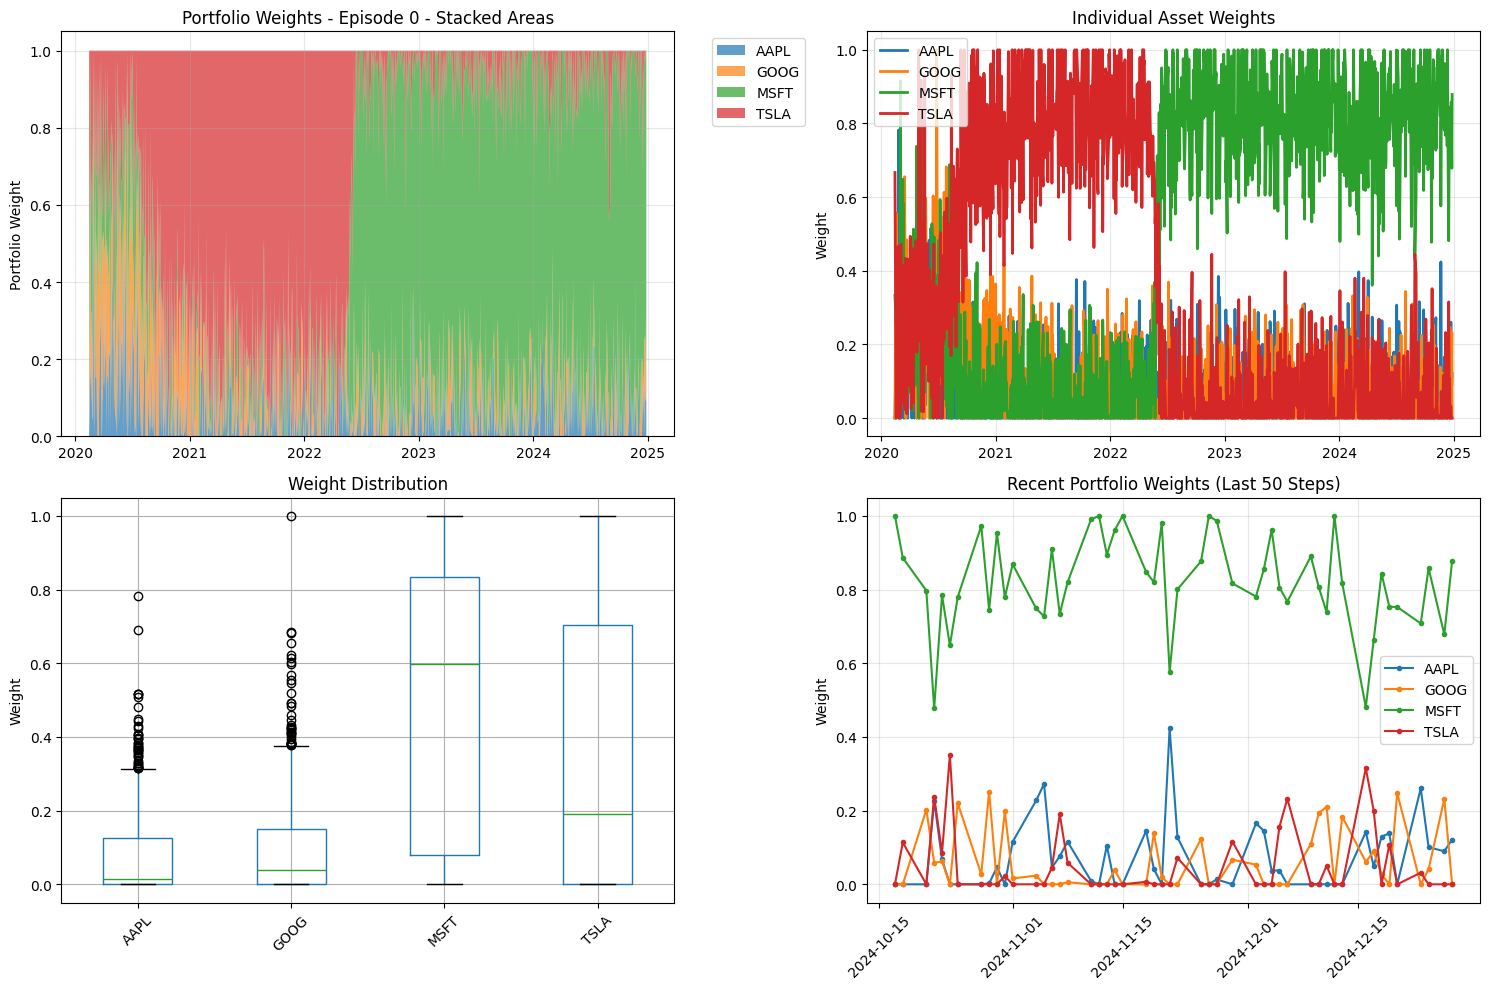

  0%|          | 1/500 [00:08<1:13:36,  8.85s/it]/tmp/ipython-input-1662995389.py:54: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  dones = torch.BoolTensor([e[4] for e in batch]).unsqueeze(1).to(self.device)
 20%|██        | 100/500 [12:41<51:40,  7.75s/it]

Episode 100, Average Reward: 2.2332


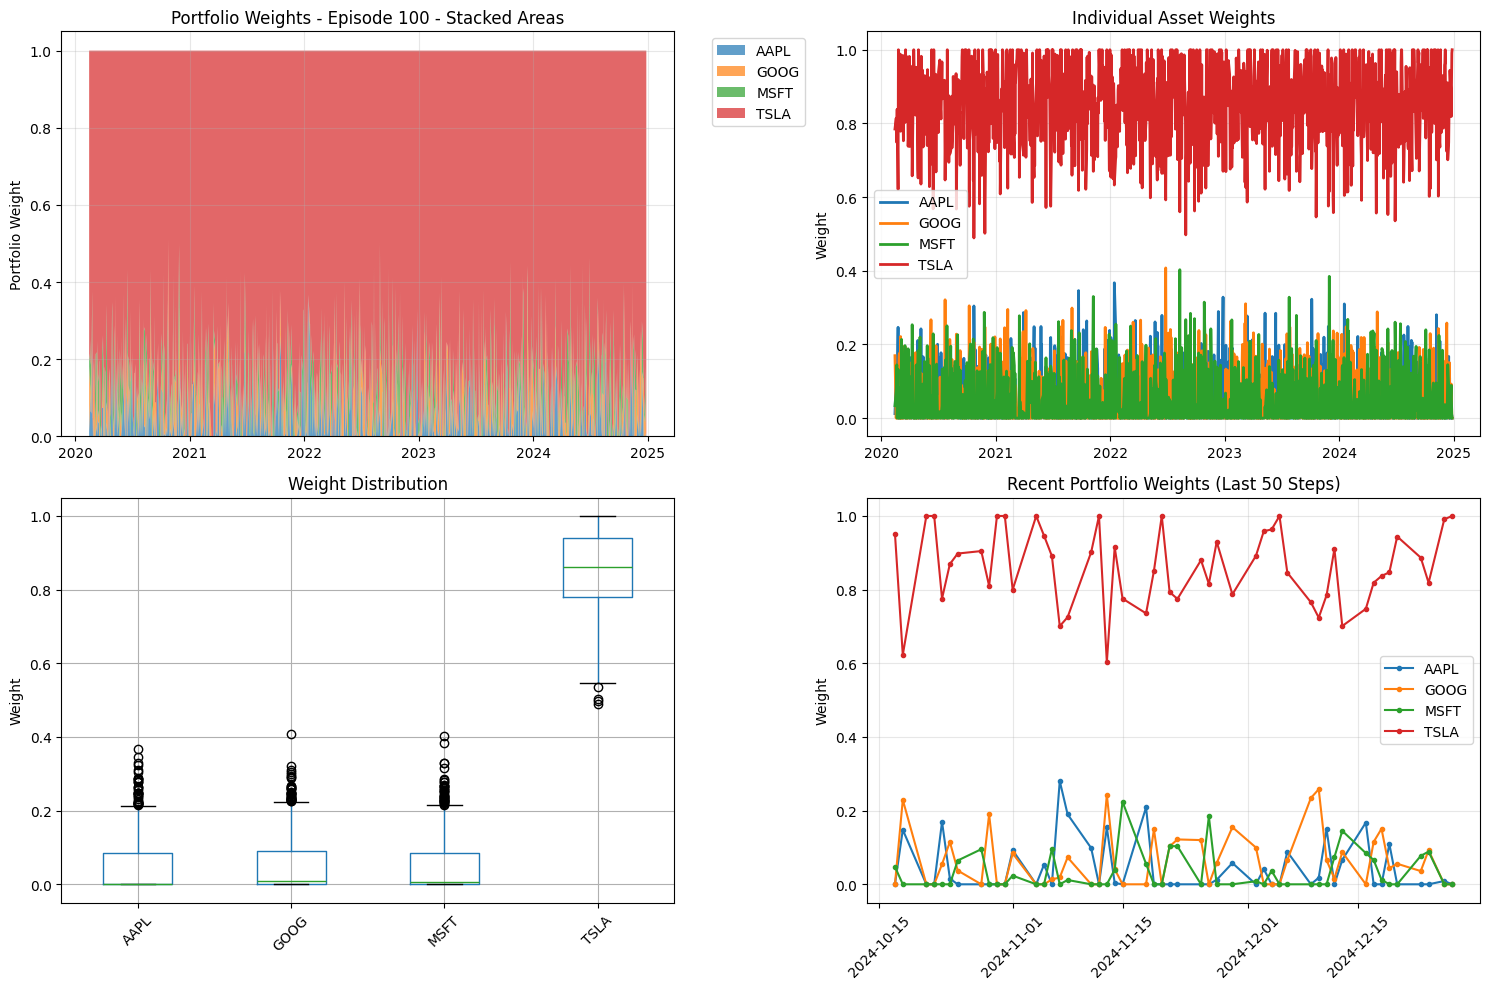

 20%|██        | 101/500 [12:49<53:03,  7.98s/it]/tmp/ipython-input-1662995389.py:54: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  dones = torch.BoolTensor([e[4] for e in batch]).unsqueeze(1).to(self.device)
 40%|████      | 200/500 [25:38<38:31,  7.70s/it]

Episode 200, Average Reward: 2.5224


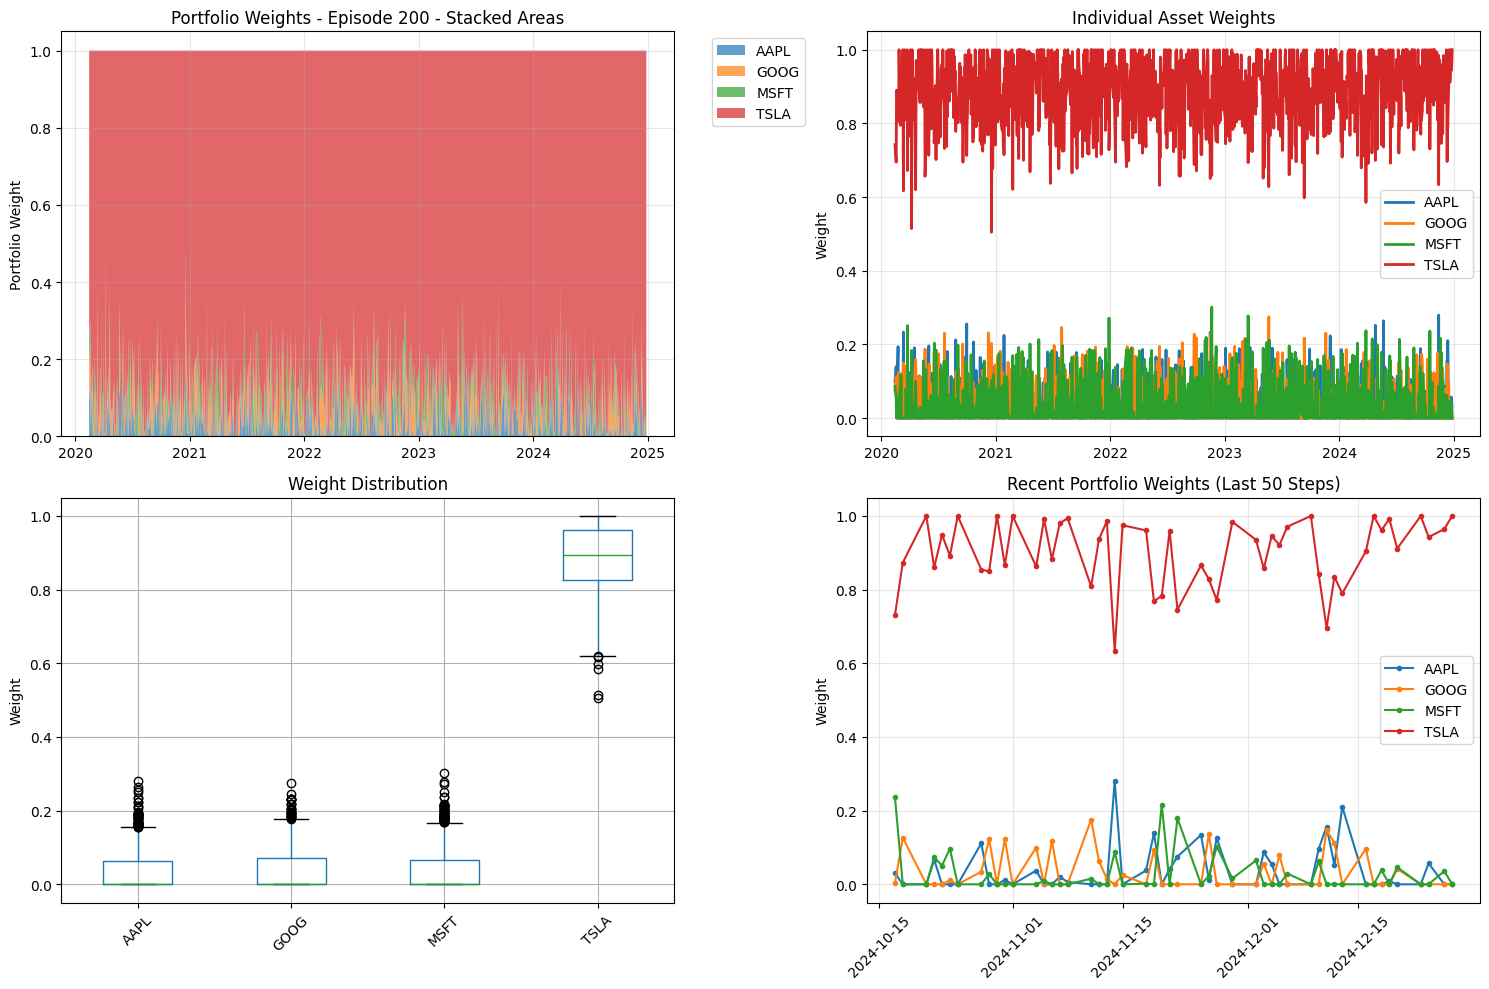

 40%|████      | 201/500 [25:47<39:51,  8.00s/it]/tmp/ipython-input-1662995389.py:54: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  dones = torch.BoolTensor([e[4] for e in batch]).unsqueeze(1).to(self.device)
 60%|██████    | 300/500 [38:34<25:47,  7.74s/it]

Episode 300, Average Reward: 2.6500


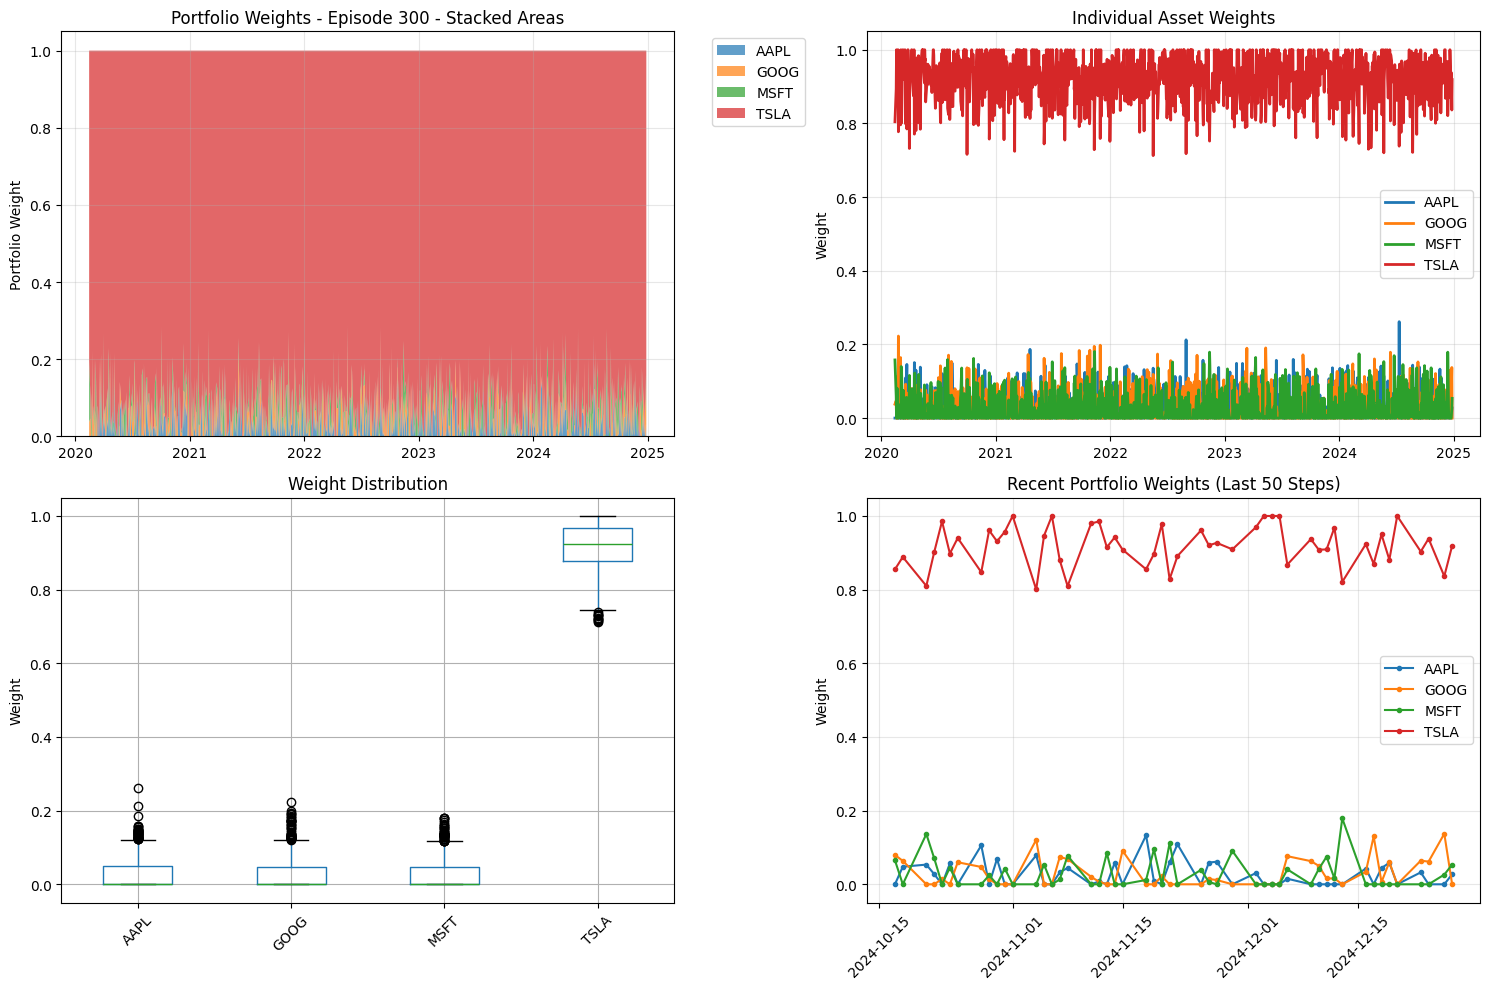

 60%|██████    | 301/500 [38:43<26:30,  7.99s/it]/tmp/ipython-input-1662995389.py:54: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  dones = torch.BoolTensor([e[4] for e in batch]).unsqueeze(1).to(self.device)
 80%|████████  | 400/500 [51:28<12:58,  7.79s/it]

Episode 400, Average Reward: 2.8232


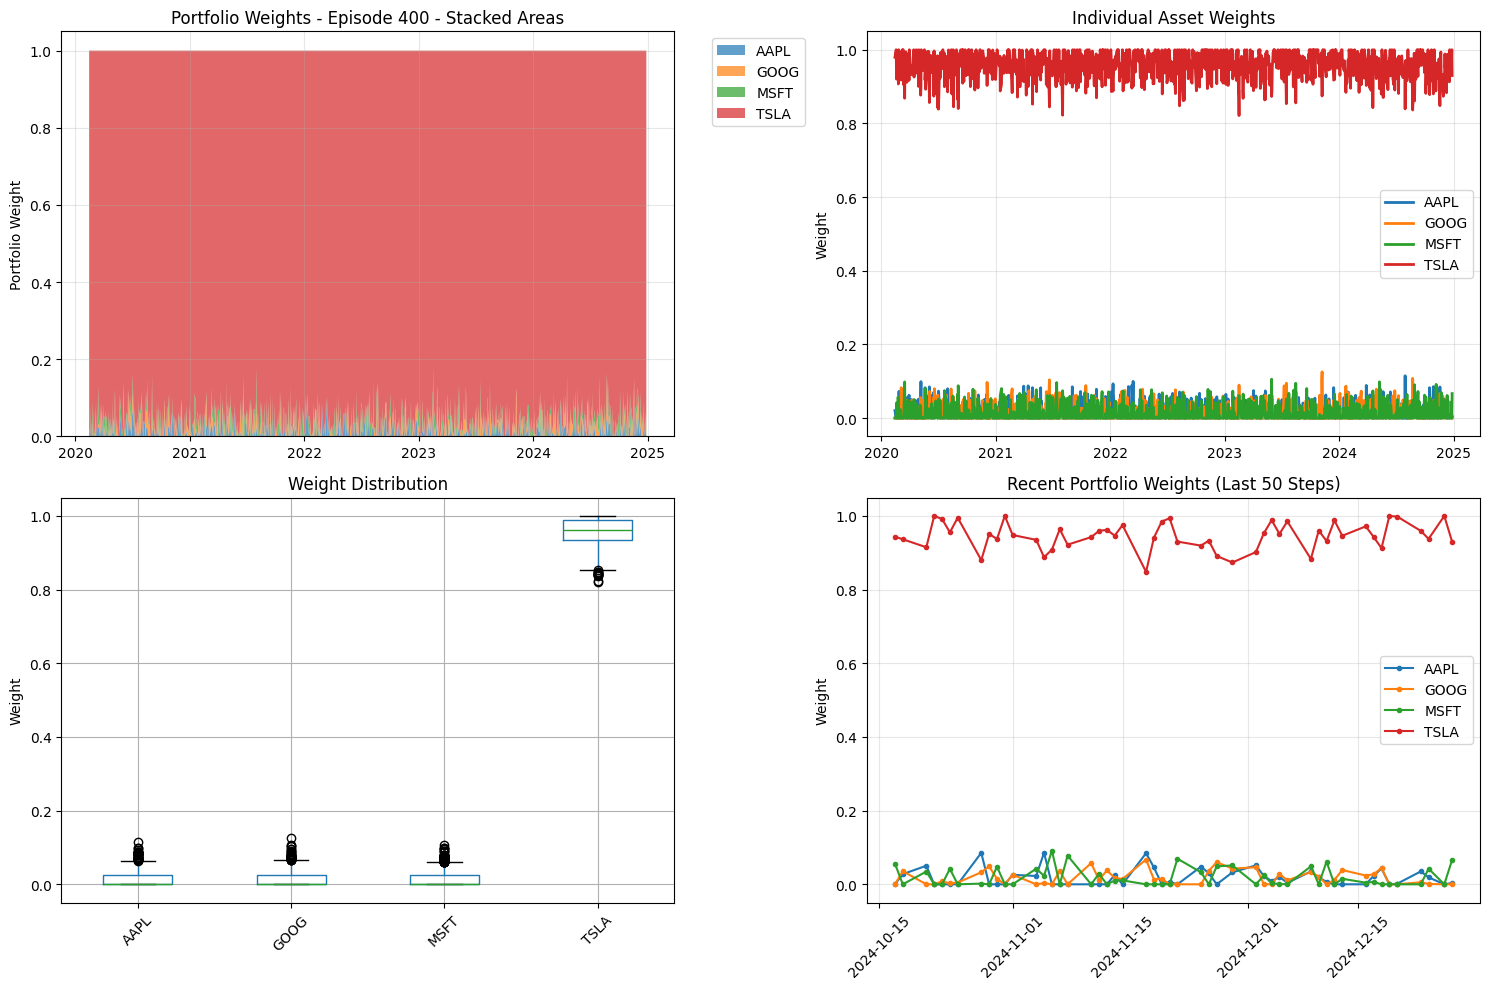

 80%|████████  | 401/500 [51:36<13:06,  7.94s/it]/tmp/ipython-input-1662995389.py:54: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  dones = torch.BoolTensor([e[4] for e in batch]).unsqueeze(1).to(self.device)
100%|██████████| 500/500 [1:04:21<00:00,  7.72s/it]


In [11]:
agent, rewards, weights_hist, values_hist, dates_hist, asset_names = train_portfolio_agent_with_tracking(
    df['Close'], episodes=500, plot_frequency=100
)

In [12]:
def plot_final_analysis(weights_history, values_history, dates_history, asset_names, rewards_history):
    """
    Comprehensive analysis plots after training
    """
    fig, axes = plt.subplots(3, 2, figsize=(20, 15))

    # Convert weights to DataFrame
    weights_df = pd.DataFrame(weights_history, columns=asset_names, index=dates_history)
    values_df = pd.Series(values_history, index=dates_history)

    # 1. Portfolio weights over time (stacked)
    ax1 = axes[0, 0]
    ax1.stackplot(weights_df.index, *[weights_df[col] for col in asset_names],
                 labels=asset_names, alpha=0.8)
    ax1.set_title('Portfolio Allocation Over Time', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Portfolio Weight')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)

    # 2. Portfolio value over time
    ax2 = axes[0, 1]
    ax2.plot(values_df.index, values_df.values, linewidth=2, color='green')
    ax2.set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Portfolio Value ($)')
    ax2.grid(True, alpha=0.3)

    # 3. Average weights per asset
    ax3 = axes[1, 0]
    avg_weights = weights_df.mean()
    bars = ax3.bar(asset_names, avg_weights, color=plt.cm.Set3(np.arange(len(asset_names))))
    ax3.set_title('Average Portfolio Weights', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Average Weight')
    ax3.set_xticklabels(asset_names, rotation=45)
    # Add value labels on bars
    for bar, weight in zip(bars, avg_weights):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{weight:.3f}', ha='center', va='bottom')

    # 4. Weight volatility (how much weights change)
    ax4 = axes[1, 1]
    weight_volatility = weights_df.std()
    bars = ax4.bar(asset_names, weight_volatility, color=plt.cm.Set2(np.arange(len(asset_names))))
    ax4.set_title('Portfolio Weight Volatility', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Weight Standard Deviation')
    ax4.set_xticklabels(asset_names, rotation=45)
    # Add value labels
    for bar, vol in zip(bars, weight_volatility):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{vol:.3f}', ha='center', va='bottom')

    # 5. Training rewards
    ax5 = axes[2, 0]
    ax5.plot(rewards_history, alpha=0.6, color='blue')
    # Add moving average
    if len(rewards_history) > 50:
        moving_avg = pd.Series(rewards_history).rolling(50).mean()
        ax5.plot(moving_avg, color='red', linewidth=2, label='50-episode MA')
        ax5.legend()
    ax5.set_title('Training Rewards Over Episodes', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Episode')
    ax5.set_ylabel('Reward')
    ax5.grid(True, alpha=0.3)

    # 6. Correlation heatmap of weights
    ax6 = axes[2, 1]
    if len(weights_df) > 1:
        correlation_matrix = weights_df.corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   ax=ax6, cbar_kws={'shrink': 0.8})
        ax6.set_title('Asset Weight Correlations', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n" + "="*60)
    print("PORTFOLIO ANALYSIS SUMMARY")
    print("="*60)
    print(f"Training Episodes: {len(rewards_history)}")
    print(f"Final Portfolio Value: ${values_df.iloc[-1]:,.2f}")
    print(f"Total Return: {((values_df.iloc[-1] / values_df.iloc[0]) - 1) * 100:.2f}%")
    print(f"Average Episode Reward: {np.mean(rewards_history):.4f}")
    print(f"Final 100-Episode Average Reward: {np.mean(rewards_history[-100:]):.4f}")

    print("\nAverage Portfolio Allocation:")
    for asset, weight in avg_weights.items():
        print(f"  {asset}: {weight:.1%}")

    print("\nPortfolio Weight Stability (lower = more stable):")
    for asset, vol in weight_volatility.items():
        print(f"  {asset}: {vol:.4f}")

/tmp/ipython-input-2960122627.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(asset_names, rotation=45)
/tmp/ipython-input-2960122627.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(asset_names, rotation=45)


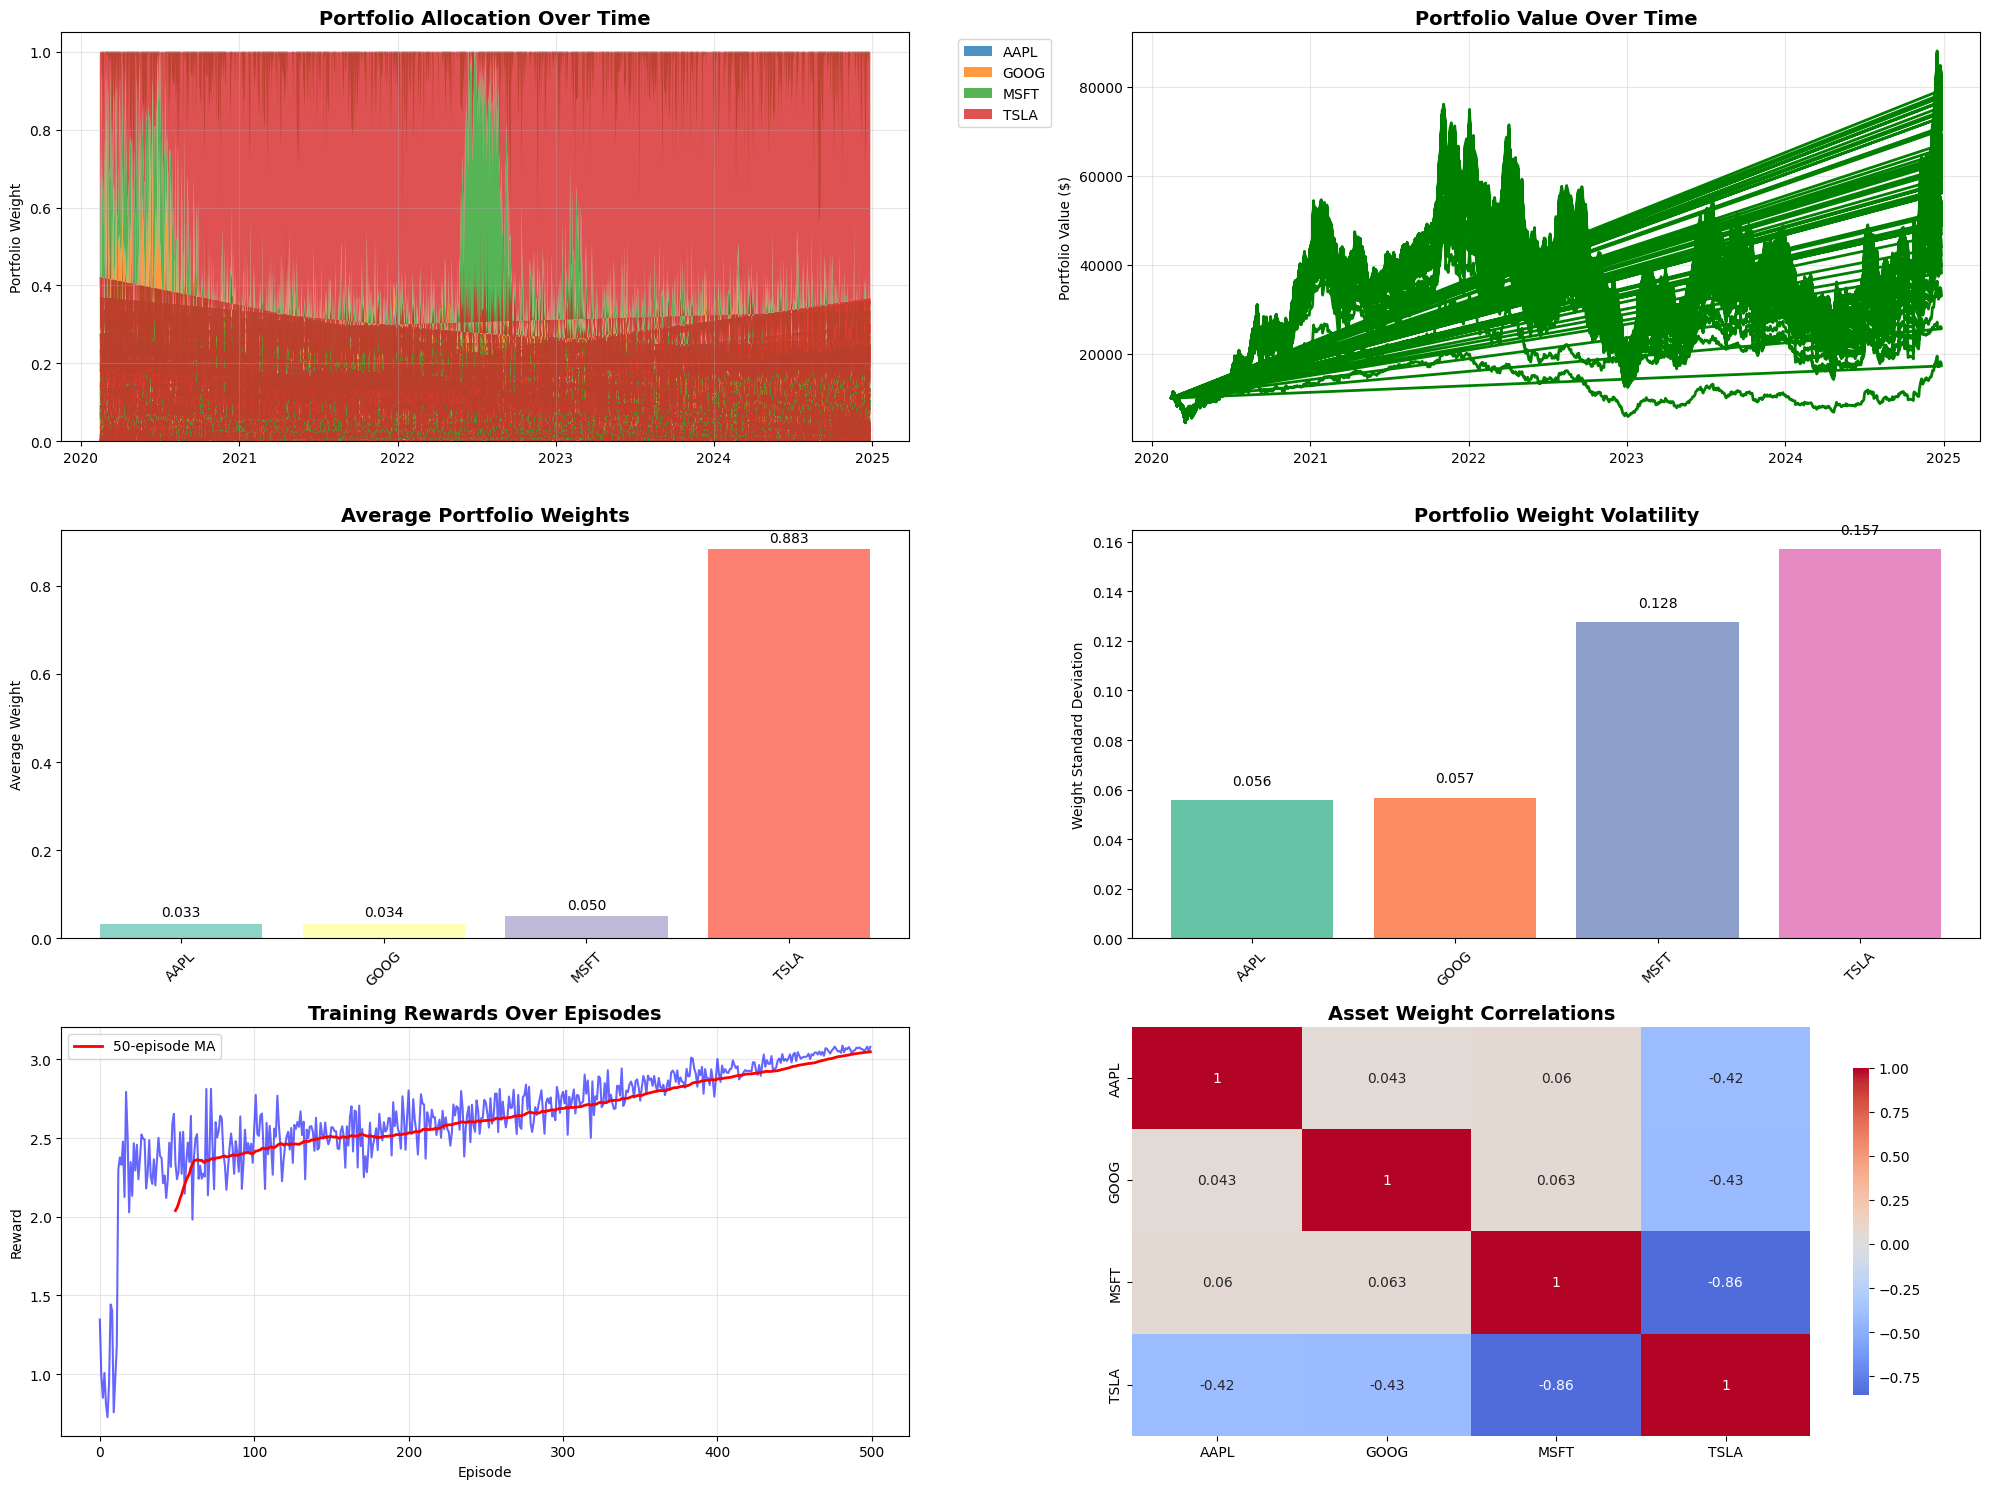


PORTFOLIO ANALYSIS SUMMARY
Training Episodes: 500
Final Portfolio Value: $78,975.11
Total Return: 690.54%
Average Episode Reward: 2.6429
Final 100-Episode Average Reward: 3.0024

Average Portfolio Allocation:
  AAPL: 3.3%
  GOOG: 3.4%
  MSFT: 5.0%
  TSLA: 88.3%

Portfolio Weight Stability (lower = more stable):
  AAPL: 0.0559
  GOOG: 0.0568
  MSFT: 0.1275
  TSLA: 0.1570


In [15]:
plot_final_analysis(weights_hist, values_hist, dates_hist, asset_names, rewards)